# 텐서플로 훑어보기 

In [59]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.4"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


텐서플로 특징 
- 넘파이와 구조가 비슷하지만 GPU를 지원한다.
- 분산 컴퓨팅을 지원한다.
- JIT(just-in-time) 컴파일러를 포함한다. 파이썬 함수에서 계산 그래프를 최적화하고 효율적으로 실행한다.
- 계산 그래프는 플랫폼에 중립적인 포맷으로 보낼 수 있기 때문에 리눅스에 있는 파이썬에서 모델을 훈련하고 안드로이드 장치에 있는 자바에서도 실행할 수 있다.
- 자동 미분 기능과 RMSProp, Nadam 같은 고성능 옵티마이저를 제공하므로 모든 종류의 손실 함수를 쉽게 최소화할 수 있다.

# 텐서플로 넘파이처럼 사용하기

## 텐서와 연산
`tf.constant()` 함수로 텐서를 만들 수 있다.

In [60]:
tf.constant([[1, 2, 3], [4, 5, 6]])

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 2, 3],
       [4, 5, 6]], dtype=int32)>

In [61]:
tf.constant(42)

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [62]:
t = tf.constant([[1, 2, 3], [4, 5, 6]])
print(t.shape)
print(t.dtype)

(2, 3)
<dtype: 'int32'>


In [63]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[2, 3],
       [5, 6]], dtype=int32)>

In [64]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[2],
       [5]], dtype=int32)>

In [65]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[11, 12, 13],
       [14, 15, 16]], dtype=int32)>

In [66]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[ 1,  4,  9],
       [16, 25, 36]], dtype=int32)>

In [67]:
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[14, 32],
       [32, 77]], dtype=int32)>

### `keras.backend` 사용하기
케라스 API는 keras.backend에 자체적인 저수준 API를 가지고 있다. square(), exp(), sqrt()와 같은 함수들이 포함된다. tf.keras에서 이런 함수들은 보통 상응하는 텐서플로 연산을 호출하는 것이 전부이다. 다른 케라스 구현에 적용할 수 있는 코드를 작성하고 싶다면 이런 케라스 함수를 사용해야 한다. 하지만 케라스 저수준 함수는 텐서플로에서 제공하는 함수의 일부만 지원한다. 여기서는 텐서플로 연산을 직접 사용한다. 보통 별칭 K를 사용한다. 

In [68]:
from tensorflow import keras
K = keras.backend
K.square(K.transpose(t)) + 10 

<tf.Tensor: shape=(3, 2), dtype=int32, numpy=
array([[11, 26],
       [14, 35],
       [19, 46]], dtype=int32)>

## 텐서와 넘파이 
텐서는 넘파이와 함께 사용하기 편리하다. 넘파이 배열로 텐서를 만들 수 있고 그 반대도 가능하다. 넘파이 배열에 텐서플로 연산을 적용할 수 있고 텐서에 넘파이 연산을 적용할 수도 있다. 

In [69]:
a = np.array([2, 4, 5])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([2, 4, 5])>

In [70]:
t.numpy()

array([[1, 2, 3],
       [4, 5, 6]], dtype=int32)

In [71]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([ 4, 16, 25])>

In [72]:
np.square(t)

array([[ 1,  4,  9],
       [16, 25, 36]], dtype=int32)

## 타입 변환 
타입 변환은 성능을 크게 감소시킬 수 있다. 타입이 자동으로 변환되면 사용자가 알아채지 못할 수도 있다. 이를 방지하기 위해 텐서플로는 어떤 타입 변환도 자동으로 수행하지 않는다. 호환되지 않는 타입의 텐서로 연산을 실행하면 예외가 발생한다. 예를 들어 실수 텐서와 정수 텐서를 더할 수 없다. 32비트 실수와 64비트 실수도 더할 수 없다.

In [73]:
try : 
    tf.constant(2.) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex : 
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2]


In [74]:
try : 
    tf.constant(2.) + tf.constant(40., dtype = tf.float64)
except tf.errors.InvalidArgumentError as ex : 
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2]


In [75]:
try : 
    tf.constant(2., dtype = tf.float64) + tf.constant(40., dtype = tf.float64)
except tf.errors.InvalidArgumentError as ex : 
    print(ex)

In [76]:
t2 = tf.constant(40., dtype = tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

## 변수
tf.Tensor는 변경이 불가능한 객체이다. 즉 텐서의 내용을 바꿀 수 없다. 따라서 일반적인 텐서로는 역전파로 변경되어야 하는 신경망의 가중치를 구현할 수 없다. 또한 시간에 따라 변경되어야 하는 다른 파라미터도 있다. 이것이 `tf.Variable`이 필요한 이유이다. 

In [77]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

tf.Variable은 tf.Tensor와 다르게 변수값을 바꿀 수 있다. 

In [78]:
v.assign(2 * v)
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [79]:
v[0, 1].assign(42)
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [80]:
v[:, 2].assign([0., 1.])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [81]:
v.scatter_nd_update(indices = [[0, 0], [1, 2]], updates = [100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

## 다른 데이터 구조 
희소 텐서
- 대부분 0으로 채워진 텐서를 효율적으로 나타낸다. `tf.sparse`는 희소 텐서를 위한 연산을 제공한다

텐서 배열
- 텐서의 리스트이다. 기본적으로 고정된 길이를 가지지만 동적으로 바꿀 수 있다. 리스트에 포함된 모든 텐서는 크기와 데이터 타입이 동일해야 한다. 

래그드 텐서
- 리스트의 리스트를 나타낸다. 텐서에 포함된 값은 동일한 데이터 타입을 가져야 하지만 리스트의 길이는 다를 수 있다. `tf.ragged` 패키지는 래그드 텐서를 위한 연산을 제공한다. 

문자열 텐서
- `tf.string` 타입의 텐서이다. 유니코드가 아니라 바이트 문자열을 나타낸다. 유니코드 문자열을 사용해서 문자열 텐서를 만들면 자동으로 UTF-8로 인코딩된다. 또는 유니코드 코드 포인트를 나타내는 tf.int32 텐서를 사용해 유니코드 문자열을 표현할 수 있다. `tf.strings`(tf.string과 다름) 패키지는 바이트 문자열과 유니코드 문자열과 이런 텐서 사이의 변환을 위한 연산을 제공한다. tf.string은 기본 데이터 타입이기 때문에 문자열의 길이가 텐서 크기에 나타나지 않는다. 

집합 
- 집합은 일반적인 텐서로 나타낸다. 예를 들면 tf.constant([[1, 2], [3, 4]])는 두 집합 {1, 2}와 {3, 4}를 나타낸다. 일반적으로 각 집합은 텐서의 마지막 축에 있는 벡터에 의해 표현된다. `tf.sets` 패키지의 연산을 통해 집합을 다룰 수 있다. 

큐
- 큐는 단계별로 텐서를 저장한다. 텐서플로는 여러 종류의 큐를 제공한다. 간단한 FIFO큐, 특정 원소에 우선권을 주는 큐, 원소를 섞는 큐, 패딩을 추가하여 크기가 다른 원소의 배치를 만드는 큐 등이 있다. `tf.queue` 패키지에 포함되어 있다. 

# 사용자 정의 모델과 훈련 알고리즘

In [82]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1),
    random_state = 42 
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state = 42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

## 사용자 정의 손실 함수
회귀 모형을 훈련하는 데 훈련 세트에 잡음 데이터가 섞여있다고 해보자. 데이터셋을 수정할 수도 있지만 비효율적일 수 있고 잡음이 여전히 섞여있을 수 있다. 이럴 때 어떤 손실 함수를 사용하는 것이 좋을까?

MSE는 큰 오차에 큰 패널티를 주기 때문에 정확하지 않은 모델이 만들어질 수 있다. MAE는 이상치에 관대하기 때문에 훈련이 수렴하는 데까지 시간이 오래 걸릴 수 있다. 그리고 정밀한 훈련이 어려울 수 있다. 

이런 경우 MSE대신 Huber loss를 사용하면 좋다. 하지만 공식 케라스 API에서 제공하지 않는다. tf.keras(`keras.losses.Huber` 클래스)에서 지원되기는 하지만 없다고 가정하고 구현해본다. 

In [83]:
def huber_fn(y_true, y_pred) :
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1 
    squared_loss = tf.square(error) / 2 
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

전체 손실의 평균이 아니라 샘플마다 하나의 손실을 담은 텐서를 반환하는 것이 좋다. 이렇게 해야 필요할 때 케라스가 클래스 가중치나 샘플 가중치를 적용할 수 있다. 

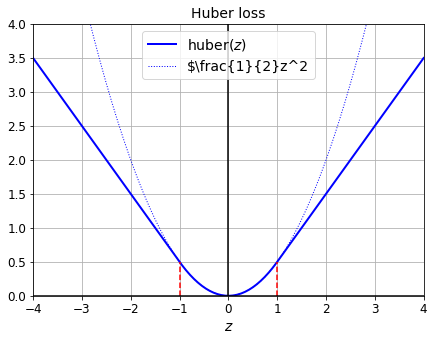

In [84]:
plt.figure(figsize = (7, 5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), 'b-', linewidth = 2, label = 'huber($z$)')
plt.plot(z, z**2/2, 'b:', linewidth = 1, label = r'$\frac{1}{2}z^2')
plt.plot([-1, -1], [0, huber_fn(0., -1.)], 'r--')
plt.plot([1, 1], [0, huber_fn(0., 1.)], 'r--')
plt.gca().axhline(y = 0, color = 'k')
plt.gca().axvline(x = 0, color = 'k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel('$z$')
plt.legend(fontsize = 14, loc = 'best')
plt.title('Huber loss', fontsize = 14)
plt.show()

In [85]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation = 'selu', kernel_initializer = 'lecun_normal',
                       input_shape = input_shape),
    keras.layers.Dense(1)
])

In [86]:
model.compile(loss = huber_fn, optimizer = 'nadam', metrics = ['mae'])

In [87]:
model.fit(X_train_scaled, y_train, epochs = 2, 
          validation_data = (X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.6235 - mae: 0.9953 - val_loss: 0.2862 - val_mae: 0.5866
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2197 - mae: 0.5177 - val_loss: 0.2382 - val_mae: 0.5281


## 사용자 정의 요소를 가진 모델을 저장하고 로드하기
케라스가 함수 이름을 저장하기 때문에 사용자 정의 손실 함수를 사용하는 모델은 아무 이상 없이 저장된다. 모델을 로드할 때는 함수 이름과 실제 함수를 매핑한 딕셔너리를 전달해야 한다. 좀 더 일반적으로 사용자 정의 객체를 포함한 모델을 로드할 때는 그 이름과 객체를 매핑해야 한다. 

In [88]:
model.save('my_model_with_a_custom_loss.h5')

In [90]:
model = keras.models.load_model('my_model_with_a_custom_loss.h5', 
                                custom_objects = {'huber_fn' : huber_fn})

model.fit(X_train_scaled, y_train, epochs = 2,
          validation_data = (X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 5ms/step - loss: 0.2054 - mae: 0.4982 - val_loss: 0.2209 - val_mae: 0.5050
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1999 - mae: 0.4900 - val_loss: 0.2127 - val_mae: 0.4986


앞서 구현한 huber loss는 -1과 1 사이의 오차는 작은 것으로 간주한다. 기준을 바꾸고 싶다면 어떤 방법이 있는가? 한 가지 방법은 매개변수를 받을 수 있는 함수를 만드는 것이다. 

In [92]:
def create_huber(threshold = 1.0) : 
    def huber_fn(y_true, y_pred) : 
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss = tf.abs(error) - threshold ** 2 / 2 
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

model.compile(loss = create_huber(2.0), optimizer = 'nadam', metrics = ['mae'])

model.fit(X_train_scaled, y_train, epochs = 2,
          validation_data = (X_valid_scaled, y_valid))

model.save("my_model_with_a_custom_loss_threshold_2.h5")

Epoch 1/2
363/363 [==============================] - 4s 5ms/step - loss: 0.1758 - mae: 0.4777 - val_loss: 0.1818 - val_mae: 0.4744
Epoch 2/2
363/363 [==============================] - 2s 4ms/step - loss: 0.1735 - mae: 0.4738 - val_loss: 0.1785 - val_mae: 0.4733


모델을 저장할 때 threshold값은 저장되지 않기 때문에 모델을 로드할 때 이 값을 지정해야 한다.

In [93]:
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

이 문제는 `keras.losses.Loss`클래스를 상속하고 `get_config()` 메서드를 구현하여 해결할 수 있다. 

In [96]:
class HuberLoss(keras.losses.Loss) : 
    def __init__(self, threshold = 1.0, **kwargs) : 
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, y_true, y_pred) : 
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    def get_config(self) : 
        base_config = super().get_config()
        return {**base_config, 'threshold' : self.threshold}

In [97]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [98]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))


Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.7095 - mae: 0.8863 - val_loss: 0.3378 - val_mae: 0.5485
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2416 - mae: 0.5083 - val_loss: 0.2660 - val_mae: 0.5089


In [101]:
model.save("my_model_with_a_custom_loss_class.h5")

model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",
                                custom_objects={"HuberLoss": HuberLoss})

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

model.loss.threshold


Epoch 1/2
363/363 [==============================] - 3s 7ms/step - loss: 0.2173 - mae: 0.4859 - val_loss: 0.2231 - val_mae: 0.4731
Epoch 2/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2143 - mae: 0.4811 - val_loss: 0.2241 - val_mae: 0.4784


2.0

In [ ]:
a